# Entity and Relation Extraction with GLiNER2

# Table of Contents

This notebook covers the complete workflow for extracting named entities from French historical documents using GLiNER2. Choose your starting point based on your needs:

## Quick Navigation

**Getting Started (First Run)**
- [Prerequisites & Setup](#prerequisites-setup) - Install dependencies and configure paths
- [GLiNER2 Basics](#gliner2-basics) - Understand the model and load it
- [Schema Configuration](#schema-configuration) - Define entities to extract

**Core Usage**
- [Single Document Extraction](#single-document-extraction) - Extract entities from one text
- [Advanced Configuration](#advanced-configuration) - Control confidence, spans, and formatting
- [Batch Processing](#batch-processing) - Extract from multiple files at once

**Post-Processing & Quality Assurance**
- [Label Studio Integration](#label-studio-integration) - Export to annotation platform
- [Evaluation & Comparison](#evaluation-comparison) - Compare predictions with human annotations
- [Troubleshooting](#troubleshooting) - Common errors and solutions

**When to Use Each Section:**
- **Exploratory work?** Start with "GLiNER2 Basics" → "Single Document Extraction"
- **Production batch extraction?** Run through "Prerequisites" → "Batch Processing" → "Label Studio Integration"
- **Validating model performance?** Use "Batch Processing" → "Evaluation & Comparison"
- **Debugging extraction quality?** Go to "Advanced Configuration" → "Troubleshooting"

## What is GLiNER2?

GLiNER2 is a lightweight, general-purpose Named Entity Recognition (NER) model that identifies entities based on user-defined labels (e.g., *person*, *company*, *disease*).

Unlike traditional NER models with fixed tag sets, GLiNER2 supports **zero-shot** and **few-shot** learning. This makes it flexible, fast, and easy to adapt to new domains without retraining.

**Resources:**
- GitHub: https://github.com/fastino-ai/GLiNER2  
- Paper: https://arxiv.org/pdf/2507.18546  
- GLINER2 models: https://huggingface.co/collections/fastino/gliner2-family   
- GLINER2 web demo: https://huggingface.co/spaces/fastino/gliner2-official-demo
---

## Important Considerations

### Duplicate Entity Values

When a sentence contains identical entity values (e.g., *“Patrick has a brother named Patrick”*), the default setting `format_results=True` returns a simplified JSON output that includes only the first occurrence.

To preserve all identical values, set:

```python
format_results = False
```

### Language Considerations

Currently, it is unclear whether using English labels and descriptions performs better than using French labels and descriptions. Further comparison is needed to determine the optimal approach.

# Prerequisites & Setup {#prerequisites-setup}

Before running this notebook, ensure you have the following in place:

## System Requirements
- **Python 3.8+** 
- **GPU recommended** (for faster inference) but CPU works
- **RAM**: 8GB minimum (16GB+ recommended for batch processing)

## Required Configuration Files
This notebook assumes you have:
- `gliner_schema_template.json` - Define your entity labels and their descriptions
- Update the `SCHEMA_CONFIG_PATH` variable below to match your file location

## Setup Checklist
- [ ] Python environment activated
- [ ] Input folder with `.txt` files identified (for batch processing)
- [ ] Output folder for exports (e.g., Downloads) ready
- [ ] `gliner_schema_template.json` created or available

## Installation & Dependencies

Run the cell below to install required packages:

In [1]:
%pip install gliner2
%pip install pandas
%pip install matplotlib

     ---------------------------------------- 0.0/83.0 kB ? eta -:--:--
     ---------------------------------------- 83.0/83.0 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/151.9 kB ? eta -:--:--
     -------------------------------------- 151.9/151.9 kB 8.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
     - -------------------------------------- 0.5/13.5 MB 16.8 MB/s eta 0:00:01
     ---- ----------------------------------- 1.5/13.5 MB 13.4 MB/s eta 0:00:01
     ------- -------------------------------- 2.6/13.5 MB 18.2 MB/s eta 0:00:01
     ----------- ---------------------------- 3.9/13.5 MB 19.1 MB/s eta 0:00:01
     --------------- ------------------------ 5.3/13.5 MB 19.7 MB/s eta 0:00:01
     ------------------- -------------------- 6.5/13.5 MB 21.8 MB/s eta 0:00:01
     ---------------------- ----------------- 7.7/13.5 MB 21.5 MB/s eta 0:00:01
     -------------------------- ------------- 9.1/13.5 MB 22.3 


[notice] A new release of pip is available: 23.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl (11.3 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     - -------------------------------------- 0.4/8.1 MB 12.2 MB/s eta 0:00:01
     -------- ------------------------------- 1.6/8.1 MB 20.7 MB/s eta 0:00:01
     ------------ --------------------------- 2.6/8.1 MB 20.7 MB/s eta 0:00:01
     ----------------- ---------------------- 3.6/8.1 MB 21.1 MB/s eta 0:00:01
     --------------------- ------------------ 4.3/8.1 MB 19.9 MB/s eta 0:00:01
     ------------------------- -------------- 5.1/8.1 MB 19.3 MB/s eta 0:00:01
     ----------------------------- ---------- 6.0/8.1 MB 19.1 MB/s eta 0:00:01
     --------------------------------- ------ 6.8/8.1 MB 18.9 MB/s eta 0:00:01
     ------------------------------------- -- 7.7/8.1 MB 18.9 MB/s eta 0:00:01
     ---------------------------------------  8.1/8.1 MB 18.6 MB/s eta 0:00:01
     ---------------------------------------- 8.1/8.1 MB 16.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/73.7 kB ? 


[notice] A new release of pip is available: 23.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## GLINER2 Model Family {#gliner2-basics}

GLiNER2 model family includes multiple pretrained variants optimized for different trade-offs between speed, size, and accuracy:

| Model | Speed | Accuracy | Best For |
|-------|-------|----------|----------|
| `fastino/gliner2-small-v1` | ⚡⚡⚡ Fast | ⭐⭐ Good | Real-time, resource-constrained |
| `fastino/gliner2-multi-v1` | ⚡⚡ Medium | ⭐⭐⭐ Excellent | **Default choice** - multilingual |
| `fastino/gliner2-large-v1` | ⚡ Slower | ⭐⭐⭐⭐ Best | Maximum accuracy, batch processing |

**Key Notes:**
- The multilingual ("multi") models support many languages out of the box and are ideal for mixed-language data
- English-focused models are optimized for best performance on English text only
- All variants share the same label-conditioned, zero-shot NER interface, so they're interchangeable in code

In [5]:
from gliner2 import GLiNER2

# Load model once, use everywhere
extractor = GLiNER2.from_pretrained("fastino/gliner2-multi-v1")
# extractor = GLiNER2.from_pretrained("fastino/gliner2-large-v1")

# Extract entities in one line
text = "Apple CEO Tim Cook announced iPhone 15 in Cupertino yesterday."
result = extractor.extract_entities(text, ["company", "person", "product", "location"])

print(result)
# {'entities': {'company': ['Apple'], 'person': ['Tim Cook'], 'product': ['iPhone 15'], 'location': ['Cupertino']}}

You are using a model of type extractor to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


🧠 Model Configuration
Encoder model      : microsoft/mdeberta-v3-base
Counting layer     : count_lstm
Token pooling      : first
{'entities': {'company': ['Apple'], 'person': ['Tim Cook'], 'product': ['iPhone 16'], 'location': ['Cupertino']}}


# Entity and Relation Schema Configuration {#schema-configuration}

Instead of defining entities and relations directly in each code cell, we use a JSON configuration file for cleaner, more maintainable configuration of our labels.

**Key Benefits:**
- **Single source of truth**: Define entities and relations once in `gliner_schema_template.json`
- **Easy customization**: Edit entity labels, descriptions, and thresholds without touching code
- **Reusable across projects**: Share schema configurations between different extraction tasks
- **Version control friendly**: Track schema changes in Git

## How It Works

1. Define your schema once in `gliner_schema_template.json`
2. Load the configuration using `load_gliner_schema_config()`
3. Create a GLiNER2 schema using `create_gliner_schema_from_config()`
4. Use the schema for extraction

## Best Practices

### Naming Conventions
Use **clear, descriptive entity names** and **provide context through label descriptions** to improve accuracy—especially for historical texts where language and structure vary.

Instead of generic labels (e.g., `thing`, `item`), define **domain-specific entities** such as:
- `PERSON_NAME` - Full name of an individual
- `ORGANIZATION` - Company, government body, or association
- `ADDRESS` - Street address with house number
- `OCCUPATION` - Job title or profession
- `DATE` - Specific date or date range

### Label Descriptions
Adding short descriptions helps the model disambiguate similar terms (e.g., a person vs. a role, or a company vs. its legal form), which is particularly important in formal French legal documents.

**Example descriptions:**
```json
{
  "PERSON_NAME": "Full name of an individual mentioned in the document",
  "NOTARY": "A legal professional who authenticates and witnesses documents"
}
```

### Relation Naming (Advanced)
When defining relations, provide **clear names and descriptions**:
- **Good:** `works_for`, `reports_to`, `manages`, `lives_at` – names clearly indicate the type
- **Less ideal:** `related`, `connected`, `linked` – too generic

## Language Choice: English vs. French {#english-vs-french}

**Current Status:** GLiNER2 works in both languages, but optimal choice depends on your use case.

### Recommendation Matrix

| Scenario | Use English Labels | Use French Labels |
|----------|-------------------|-------------------|
| Historical French documents | ✓ **Recommended** | Test side-by-side |
| Mixed language datasets | ✓ Default | - |
| Known entity domain | - | Potentially better |
| Unsure / exploratory phase | ✓ Start here | - |

**How to switch:** Edit `gliner_schema_template.json` and change entity names/descriptions to French, then reload the schema.

**Tip:** The cell marked "Alternative version with French labels" below demonstrates how to load French versions. Run both and compare results on your data to see which performs better.

## Customizing the Schema

To customize the schema for your specific use case, edit `gliner_schema_template.json`:

1. **Add/Remove Entities**: Add new entity labels or delete ones you don't need
2. **Adjust Thresholds**: Lower threshold for more liberal extraction, raise for stricter
3. **Improve Descriptions**: More detailed descriptions help the model understand what to extract
4. **Add Relations**: Define relationships between entities

Example structure:
```json
{
  "schema_name": "Your Schema Name",
  "entities": {
    "ENTITY_NAME": {
      "description": "Clear description of what this entity represents",
      "threshold": 0.5
    }
  },
  "relations": {
    "RELATION_NAME": {
      "description": "Description of the relationship",
      "threshold": 0.5
    }
  }
}
```

Then use `create_gliner_schema_from_config_file(extractor, SCHEMA_CONFIG_PATH)` to load it in any cell.


In [6]:
# Load schema configuration functions
from gliner_to_labelstudio import (
    load_gliner_schema_config,
    create_gliner_schema_from_config,
    create_gliner_schema_from_config_file,
    get_schema_metadata
)

# Path to the schema configuration file
SCHEMA_CONFIG_PATH = 'gliner_schema_template.json'

# Option 1: Load schema configuration
schema_config = load_gliner_schema_config(SCHEMA_CONFIG_PATH)

# Display schema metadata
metadata = get_schema_metadata(schema_config)
print("✓ Schema Loaded Successfully")
print(f"  Schema Name: {metadata['schema_name']}")
print(f"  Version: {metadata['schema_version']}")
print(f"  Entities: {metadata['num_entities']}")
print(f"  Relations: {metadata['num_relations']}")
print(f"  Model: {metadata['model_version']}")

✓ Schema Loaded Successfully
  Schema Name: Historical French NER
  Version: 1.0
  Entities: 20
  Relations: 0
  Model: fastino/gliner2-multi-v1


## French Historical NER Example {#single-document-extraction}

This example shows how to use GLiNER2 to extract named entities (e.g., people, places, organizations) from a short French historical document.

The entity schema is loaded from an external configuration file, and the extracted entities are returned in JSON format.

**Important Limits & Notes:**
- GLiNER2 supports a maximum input length of **2048 tokens** (~8000 characters)
- Longer texts must be split into smaller chunks
- **Best practice:** Shorter and more focused passages usually produce better results
- The sample text below is from a 19th-century Belgian company deed

**What to expect in the output:**
- Entity label (e.g., "PERSON_NAME", "ADDRESS")
- Extracted text
- Character position (start/end indices)
- Confidence score (higher = more certain)

In [8]:
import json

# Create schema from config file (instead of defining inline)
schema = create_gliner_schema_from_config_file(extractor, SCHEMA_CONFIG_PATH)

historical_text = """
1367 L'Eurite, societe anonyme, a Bruxelles. Acte constitutif. Par-devant Me Hilaire Groensteen, notaire a Laeken.
Sont comparus:
M. Jean Parentani, directeur d'usine, et son epouse qu'il assiste et autorise, dame Celine Baudoux, demeurant ensemble a Bruxelles, avenue des Courses, n 37.
"""
results = extractor.extract(historical_text, schema, format_results=False)
print(json.dumps(results, indent=2, ensure_ascii=False))


{
  "entities": [
    {
      "DATE": [
        "1367"
      ],
      "ORGANIZATION": [
        "societe anonyme"
      ],
      "LEGAL_STRUCTURE": [
        "societe anonyme"
      ],
      "MISSION_STATEMENT": [],
      "DURATION": [],
      "LEGAL_PROCEDURE": [
        "Acte constitutif"
      ],
      "REGISTERED_OFFICE": [],
      "PERSON": [
        "Hilaire Groensteen",
        "Celine Baudoux",
        "Jean Parentani"
      ],
      "HONORIFICS": [
        "Me",
        "M."
      ],
      "PROFESSION": [
        "notaire"
      ],
      "CORPORATE_TITLE": [
        "directeur d'usine"
      ],
      "SHARE_QUANTITY": [],
      "SHARE_TYPE": [],
      "SHARE_VALUE": [],
      "CAPITAL_TYPE": [],
      "COUNTRY": [],
      "CITY": [
        "Bruxelles",
        "Bruxelles",
        "Laeken"
      ],
      "ADDRESS": [
        "avenue des Courses, n 37"
      ],
      "BUILDING_NAME": [],
      "ARCHIVAL_REFERENCE": []
    }
  ]
}


# Advanced Configuration {#advanced-configuration}

GLINER2 provides multiple parameters to control extraction behavior at inference time:

| Parameter | Purpose | Values |
|-----------|---------|--------|
| `threshold` | Global confidence cutoff | 0.0-1.0 (default: 0.3) |
| `include_confidence` | Add confidence scores to output | `True` / `False` |
| `include_spans` | Add character positions | `True` / `False` |
| `format_results` | Simplify output (removes duplicates) | `True` / `False` |

**Key Trade-offs:**
- **Lower threshold** = More entities found but more false positives
- **Higher threshold** = Stricter but may miss valid entities
- **format_results=True** = Cleaner output but loses duplicate entities
- **format_results=False** = Complete output including all occurrences

## With Confidence Scores and Character Positions
You can include confidence scores and character-level start/end positions using include_confidence and include_spans parameters:

In [9]:
import json

# Load and create schema from config file
schema = create_gliner_schema_from_config_file(extractor, SCHEMA_CONFIG_PATH)

historical_text="""
1367 L'Eurite, societe anonyme, a Bruxelles. Acte constitutif. Par-devant Me Hilaire Groensteen, notaire a Laeken.
Sont comparus:
dame Barbara Baudouxas, demeurant ensemble a Bruxelles, avenue des Courses, n 378.
"""
# Inclusion of both confidence scores and character spans in the output
results = extractor.extract(historical_text, schema, threshold=0.1, include_confidence=True, include_spans=True, format_results=False)
print(json.dumps(results, indent=2, ensure_ascii=False))


{
  "entities": [
    {
      "DATE": [
        {
          "text": "1367",
          "confidence": 0.866828203201294,
          "start": 1,
          "end": 5
        }
      ],
      "ORGANIZATION": [
        {
          "text": "societe anonyme",
          "confidence": 0.5572052597999573,
          "start": 16,
          "end": 31
        }
      ],
      "LEGAL_STRUCTURE": [
        {
          "text": "societe anonyme",
          "confidence": 0.5122087001800537,
          "start": 16,
          "end": 31
        }
      ],
      "MISSION_STATEMENT": [],
      "DURATION": [],
      "LEGAL_PROCEDURE": [
        {
          "text": "Acte constitutif",
          "confidence": 0.9548839926719666,
          "start": 46,
          "end": 62
        }
      ],
      "REGISTERED_OFFICE": [],
      "PERSON": [
        {
          "text": "Hilaire Groensteen",
          "confidence": 0.8677926659584045,
          "start": 78,
          "end": 96
        },
        {
          "text": "Barb

### Explanation

In the output above, each detected entity is returned together with its **character span**, which defines *where* the entity appears in the text and *how long* it is. Spans use **0-based indexing**, meaning that if an entity starts at the very beginning of the text, its first character has index `0`.

The **confidence score** is especially useful for interpreting results. It highlights which entities the model is uncertain about and often points to issues in the schema rather than the text itself. Low confidence may indicate that:
- the entity label is too vague,
- the label description lacks clarity, or
- the entity is highly contextual or nuanced.

NER models perform best on **clear, self-contained entities**. While GLiNER2 can leverage some semantic understanding through label names and descriptions, it is not designed to resolve ambiguous or debatable cases. A good rule of thumb: if two human annotators would reasonably disagree on whether something should be labeled as an entity, the model will likely assign it a low confidence—suggesting it may not be a strong candidate for an NER label.


## GLiNER2 Regex Validators
Regex validators filter extracted spans to ensure they match expected patterns, improving extraction quality and reducing false positives.

https://github.com/fastino-ai/GLiNER2/blob/main/tutorial/5-validator.md

# Parsing GLiNER2 Pre-Annotations for Label Studio {#label-studio-integration}

Manual annotation is time-consuming. To support human annotators, we can load model-generated pre-annotations (e.g., from GLiNER2) into an annotation tool such as Label Studio. This allows annotators to focus on validating and correcting existing labels rather than annotating from scratch.

## Workflow
1. Extract entities using GLiNER2
2. Convert results to Label Studio format (maintains confidence scores)
3. Export as JSON
4. Import into Label Studio as pre-annotations
5. Human annotators validate/correct (see Evaluation section)

## Expected Result
- Each extracted entity becomes a pre-annotation
- Confidence scores help annotators identify low-confidence predictions to review
- Annotators can quickly accept, modify, or reject each prediction

**Current Status:** Entity annotations are fully supported. Relationship annotations are not yet imported.

## Next Steps (After Import)
1. Annotators validate entities in Label Studio
2. Export validated annotations
3. Compare with predictions using the Evaluation section below

In [10]:
import json

# Load schema from config file
schema = create_gliner_schema_from_config_file(extractor, SCHEMA_CONFIG_PATH)

# Historical French text sample
historical_text = """
1367 L'Eurite, societe anonyme, a Bruxelles. Acte constitutif. Par-devant Me Hilaire Groensteen, notaire a Laeken.
Sont comparus:
M. Jean Parentani, directeur d'usine, et son epouse qu'il assiste et autorise, dame Celine Baudoux, demeurant ensemble a Bruxelles, avenue des Courses, n 37.
"""

# Extract entities and relations, including confidence and character spans
results = extractor.extract(
    historical_text,
    schema,
    include_confidence=True,
    include_spans=True,
    format_results=False
)

# Pretty-print results
print(json.dumps(results, indent=2, ensure_ascii=False))


{
  "entities": [
    {
      "DATE": [
        {
          "text": "1367",
          "confidence": 0.8762015104293823,
          "start": 1,
          "end": 5
        }
      ],
      "ORGANIZATION": [
        {
          "text": "societe anonyme",
          "confidence": 0.5870721340179443,
          "start": 16,
          "end": 31
        }
      ],
      "LEGAL_STRUCTURE": [
        {
          "text": "societe anonyme",
          "confidence": 0.6005704998970032,
          "start": 16,
          "end": 31
        }
      ],
      "MISSION_STATEMENT": [],
      "DURATION": [],
      "LEGAL_PROCEDURE": [
        {
          "text": "Acte constitutif",
          "confidence": 0.9537531733512878,
          "start": 46,
          "end": 62
        }
      ],
      "REGISTERED_OFFICE": [],
      "PERSON": [
        {
          "text": "Hilaire Groensteen",
          "confidence": 0.9383396506309509,
          "start": 78,
          "end": 96
        },
        {
          "text": "Cel

In [26]:
from gliner_to_labelstudio import (
    gliner_to_labelstudio_predictions,
    create_labelstudio_task,
    batch_convert_gliner_to_labelstudio,
    convert_gliner_json_file
)

## Example 1: Convert a Single GLiNER2 Result

Convert the current extraction results to Label Studio pre-annotation format for a single document.

In [12]:
# Convert the results from the previous cell to Label Studio predictions
# results contains the GLiNER2 output with entities and confidence scores

# Create a single Label Studio task with predictions
ls_task = create_labelstudio_task(
    text=historical_text,
    gliner_output=results,
    model_version="gliner2-multi-v1"
)

# Show the predictions array
print("Label Studio Predictions:")
print(results)
#print(json.dumps(ls_task["predictions"], indent=2, ensure_ascii=False))

Label Studio Predictions:
{'entities': [OrderedDict([('DATE', [{'text': '1367', 'confidence': 0.8762015104293823, 'start': 1, 'end': 5}]), ('ORGANIZATION', [{'text': 'societe anonyme', 'confidence': 0.5870721340179443, 'start': 16, 'end': 31}]), ('LEGAL_STRUCTURE', [{'text': 'societe anonyme', 'confidence': 0.6005704998970032, 'start': 16, 'end': 31}]), ('MISSION_STATEMENT', []), ('DURATION', []), ('LEGAL_PROCEDURE', [{'text': 'Acte constitutif', 'confidence': 0.9537531733512878, 'start': 46, 'end': 62}]), ('REGISTERED_OFFICE', []), ('PERSON', [{'text': 'Hilaire Groensteen', 'confidence': 0.9383396506309509, 'start': 78, 'end': 96}, {'text': 'Celine Baudoux', 'confidence': 0.9239786267280579, 'start': 215, 'end': 229}, {'text': 'Jean Parentani', 'confidence': 0.8462709188461304, 'start': 134, 'end': 148}]), ('HONORIFICS', [{'text': 'Me', 'confidence': 0.826697826385498, 'start': 75, 'end': 77}, {'text': 'M.', 'confidence': 0.6201156377792358, 'start': 131, 'end': 133}]), ('PROFESSION',

## Example 2: Export Full Task for Label Studio Import

Export the complete task with data and predictions to a JSON file that can be imported into Label Studio.

In [13]:
# Save the complete task to a JSON file for Label Studio import
output_file = 'labelstudio_preannotations.json'

# Save as a list with a single task (Label Studio expects an array)
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump([ls_task], f, indent=2, ensure_ascii=False)

print(f"✓ Exported Label Studio pre-annotations to: {output_file}")
print(f"✓ Contains {len(ls_task['predictions'][0]['result'])} entity predictions")
print(f"✓ Average confidence score: {ls_task['predictions'][0]['score']:.2%}")

✓ Exported Label Studio pre-annotations to: labelstudio_preannotations.json
✓ Contains 15 entity predictions
✓ Average confidence score: 86.39%


## How to Import into Label Studio

### Via the Command Line (Full File Mode)

1. Place your GLiNER2 JSON output in a file (e.g., `gliner_output.json`)
2. Run the conversion:
```bash
python gliner_to_labelstudio.py gliner_output.json labelstudio_preannotations.json
```

3. In Label Studio:
   - Go to your project settings → **Import**
   - Select the generated JSON file
   - Choose **Import as pre-annotations**

### Via API or Manual Import

If you're using Label Studio's API, you can POST the pre-annotation data directly to your project with:

```python
import requests

# Your Label Studio instance
API_TOKEN = "your-label-studio-api-token"
PROJECT_ID = 43  # Your project ID
LABEL_STUDIO_URL = "http://localhost:8080"  # Or your production URL

# Load the pre-annotations
with open('labelstudio_preannotations.json', 'r') as f:
    predictions = json.load(f)

# Create tasks with predictions
for task_data in predictions:
    response = requests.post(
        f"{LABEL_STUDIO_URL}/api/tasks",
        headers={"Authorization": f"Token {API_TOKEN}"},
        json={
            "data": task_data["data"],
            "project": PROJECT_ID,
            "predictions": task_data["predictions"]
        }
    )
    print(f"Task created: {response.json()['id']}")
```

# Batch Processing: Extract NER from multiple Text Files {#batch-processing}

Process all `.txt` files from a folder, extract entities with GLiNER2, and export to Label Studio format in one go.

## Prerequisites for This Section
Before running batch processing, ensure:
- ✓ Model is loaded (`extractor` variable exists)
- ✓ Schema configuration is loaded (`SCHEMA_CONFIG_PATH` is set)
- ✓ Input folder contains `.txt` files
- ✓ Output folder exists for saving results

## Workflow Overview
1. **Step 1:** Load text files into memory
2. **Step 2:** Extract entities using your schema
3. **Step 3:** Display and validate results
4. **Step 4:** (Optional) View full JSON output
5. **Step 5:** Convert to Label Studio format
6. **Step 6:** Save and export

# Step 0: Text Preprocessing (Optional)

## When Preprocessing Helps

Text preprocessing can improve extraction quality for domain-specific formats. Common issues:

| Problem | Solution | Example |
|---------|----------|---------|
| House numbers with "n°" | Replace with full word | "n 37" → "house number 37" |
| Inconsistent spacing | Normalize whitespace | "M.' ' 'Jean" → "M. Jean" |
| Special characters | Map to equivalents | "é" → "e" (if encoding issues) |
| Line breaks in entities | Join lines strategically | Keep them for addresses |

## Known Issues with Current Format

- GLiNER2 does **not reliably detect house numbers** when preceded by "n°"
- Solution 1: Replace "n°" with "number" or "house number" (requires preprocessing)
- Solution 2: Add examples to schema descriptions (no preprocessing needed)
- Solution 3: Fine-tune model with LORA on your specific format

## Recommended Approach

**For quick wins:** Try adjusting the entity description in your schema first:
```json
{
  "ADDRESS": "Street name and house number (may include 'n°', 'rue', 'avenue')"
}
```

**If still not working:** Implement preprocessing below or contact the model authors.

**Note:** This notebook currently does not include preprocessing. If you need it, implement a preprocessing function and apply it in Step 1 before extracting entities.

## Step 1: Load All Text Files

Read all `.txt` files from your Downloads folder into a list of texts.

A first test can be done with the '.txt' files in the 'example_texts' folder. These have company records both fully in French 'FR' of combined French-Dutch 'FR-NL'

In [25]:
import glob
import os

# Define the folder containing your .txt files
input_folder = 'example_texts'

# Find all .txt files in the folder
txt_files = glob.glob(os.path.join(input_folder, '*.txt'))

# Load all texts and keep track of filenames
texts_batch = []
filenames = []

for txt_file in txt_files:
    with open(txt_file, 'r', encoding='utf-8') as f:
        text = f.read()
        texts_batch.append(text)
        filenames.append(os.path.basename(txt_file))

print(f"✓ Loaded {len(texts_batch)} text files from {input_folder}")
for i, filename in enumerate(filenames):
    print(f"  {i+1}. {filename} ({len(texts_batch[i])} characters)")

✓ Loaded 5 text files from example_texts
  1. EHC_B665_O_2025_1909_III_0013_LayoutElement_1_Text[FR].txt (2531 characters)
  2. EHC_B665_O_2025_1909_III_0044_LayoutElement_1_Text[FR].txt (2938 characters)
  3. EHC_B665_O_2025_1909_III_0063_LayoutElement_1_Text[FR-NL].txt (2296 characters)
  4. EHC_B665_O_2025_1909_III_0067_LayoutElement_2_Text[NL-FR].txt (463 characters)
  5. EHC_B665_O_2025_1909_III_0067_LayoutElement_4_Text[NL-FR].txt (496 characters)


## Step 1b: Preprocess OCR Text (Optional)

Apply preprocessing to fix common OCR errors that can affect NER accuracy:
- **Hyphenated line breaks**: Remove hyphens when words are split across lines
- **Missing spaces after punctuation**: Add space after period, comma, etc.
- **Multiple consecutive spaces**: Normalize to single space
- **Missing spaces before capital letters**: Add space before capitals after lowercase

These preprocessing steps help GLiNER2 better identify entity boundaries.

In [15]:
import re

def preprocess_ocr_text(text: str) -> str:
    """
    Clean up common OCR errors in French historical documents.
    
    Args:
        text: Raw OCR text
    
    Returns:
        Cleaned text with improved formatting
    """
    # 1. Remove hyphens at line breaks (word split across lines)
    # Match: hyphen followed by newline, then lowercase letter
    # Example: "resi-\ndant" -> "residant"
    text = re.sub(r'-\s*\n\s*([a-zàâäéèêëïîôùûüÿæœç])', r'\1', text)
    
    # 2. Replace 'n°' with 'numéro' for better house number detection
    # Example: "n 37" -> "numéro 37"
    text = re.sub(r'n°\s*', 'numéro ', text, flags=re.IGNORECASE)
    
    # 3. Remove unnecessary whitespace before colons
    # Example: "suivants :" -> "suivants:"
    text = re.sub(r'\s+:', ':', text)
    
    # 4. Add space after period if missing (common OCR error)
    # Match: period followed immediately by lowercase or uppercase letter
    # Example: "notaire.residant" -> "notaire. residant" or "word.Word" -> "word. Word"
    text = re.sub(r'\.([A-ZÀÂÄÉÈÊËÏÎÔÙÛÜŸÆŒÇa-zàâäéèêëïîôùûüÿæœç])', r'. \1', text)
    
    # 5. Add space after comma if missing
    # Example: "Bruxelles,rue" -> "Bruxelles, rue"
    text = re.sub(r',([A-ZÀÂÄÉÈÊËÏÎÔÙÛÜŸÆŒÇa-zàâäéèêëïîôùûüÿæœç])', r', \1', text)
    
    # 6. Add space after semicolon if missing
    text = re.sub(r';([A-ZÀÂÄÉÈÊËÏÎÔÙÛÜŸÆŒÇa-zàâäéèêëïîôùûüÿæœç])', r'; \1', text)
    
    # 7. Add space before opening parenthesis if preceded by letter
    # Example: "société(anciens" -> "société (anciens"
    text = re.sub(r'([a-zàâäéèêëïîôùûüÿæœç])\(', r'\1 (', text)
    
    # 8. Remove newlines within sentences (preserve paragraph breaks)
    # Match: newline between letters or after comma/semicolon
    # Example: "mot\nmot" -> "mot mot"
    text = re.sub(r'([a-zàâäéèêëïîôùûüÿæœç,;])\n([a-zàâäéèêëïîôùûüÿæœçA-ZÀÂÄÉÈÊËÏÎÔÙÛÜŸÆŒÇ])', r'\1 \2', text)
    
    # 9. Normalize multiple spaces to single space
    text = re.sub(r' {2,}', ' ', text)
    
    # 10. Normalize multiple newlines (keep max 2 for paragraph breaks)
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 11. Remove trailing/leading whitespace from each line
    lines = text.split('\n')
    lines = [line.strip() for line in lines]
    text = '\n'.join(lines)
    
    return text


# Apply preprocessing to all loaded texts
print(f"Preprocessing {len(texts_batch)} documents...")
texts_batch_cleaned = []

for i, text in enumerate(texts_batch):
    cleaned = preprocess_ocr_text(text)
    texts_batch_cleaned.append(cleaned)
    
    # Show changes for first document as example
    if i == 0:
        print(f"\n📝 Example changes in first document:")
        print(f"  Original length: {len(text)} characters")
        print(f"  Cleaned length:  {len(cleaned)} characters")
        print(f"  Difference:      {len(text) - len(cleaned)} characters removed")

print(f"\n✓ Preprocessing complete! All {len(texts_batch)} documents cleaned.")

# Replace the original texts with cleaned versions
texts_batch = texts_batch_cleaned

Preprocessing 5 documents...

📝 Example changes in first document:
  Original length: 2531 characters
  Cleaned length:  2539 characters
  Difference:      -8 characters removed

✓ Preprocessing complete! All 5 documents cleaned.


## (Optional) View Before/After Preprocessing

Compare original OCR text with cleaned version to verify preprocessing worked correctly.

In [16]:
# Show a sample of the first document before/after preprocessing
# To see a different document, change the index below

doc_index = 0  # Change to view different document (0 = first, 1 = second, etc.)

# Get original text by reloading the file
txt_file = txt_files[doc_index]
with open(txt_file, 'r', encoding='utf-8') as f:
    original_text = f.read()

cleaned_text = texts_batch[doc_index]

# Show first 800 characters of each
print("=" * 80)
print("ORIGINAL TEXT (first 800 chars):")
print("=" * 80)
print(original_text[:800])
print("\n")

print("=" * 80)
print("CLEANED TEXT (first 800 chars):")
print("=" * 80)
print(cleaned_text[:800])
print("\n")

print("=" * 80)
print("CHANGES APPLIED:")
print("=" * 80)

# Count specific changes
hyphen_breaks_removed = len(re.findall(r'-\s*\n\s*[a-zàâäéèêëïîôùûüÿæœç]', original_text))
missing_spaces_fixed = len(re.findall(r'\.[A-ZÀÂÄÉÈÊËÏÎÔÙÛÜŸÆŒÇa-zàâäéèêëïîôùûüÿæœç]', original_text))
multiple_spaces = len(re.findall(r' {2,}', original_text))
newlines_in_sentences = len(re.findall(r'[a-zàâäéèêëïîôùûüÿæœç,;]\n[a-zàâäéèêëïîôùûüÿæœçA-ZÀÂÄÉÈÊËÏÎÔÙÛÜŸÆŒÇ]', original_text))
n_degrees_replaced = len(re.findall(r'n°\s*', original_text, flags=re.IGNORECASE))
spaces_before_colons = len(re.findall(r'\s+:', original_text))

print(f"  • Hyphenated line breaks removed: {hyphen_breaks_removed}")
print(f"  • 'n°' replaced with 'numéro': {n_degrees_replaced}")
print(f"  • Unnecessary spaces before colons removed: {spaces_before_colons}")
print(f"  • Missing spaces after period fixed: {missing_spaces_fixed}")
print(f"  • Newlines within sentences removed: {newlines_in_sentences}")
print(f"  • Multiple consecutive spaces normalized: {multiple_spaces}")
print(f"  • Total characters: {len(original_text)} → {len(cleaned_text)} ({len(original_text) - len(cleaned_text):+d})")

ORIGINAL TEXT (first 800 chars):
L'assemblée, après délibération, fixe à cinq le nombre des administrateurs et, à l'unanimité, appelle à ces fonctions MM. Van den Brande, Van In, Bauwens, Lambin et Sutens.

soixante mille francs, y souscrire en mon nom deux actions de cinq cents francs chacune, faire sur ces actions les versements statutaires.

Assister à l'assemblée générale qui se tiendra après la constitution de la société, à l'effet de nommer les membres du conseil d'administration.

La séance continue.

Aux effets ci-dessus, passer et signer tous actes et procès-verbaux, substituer en tout ou en partie des présents pouvoirs et, en général, faire tout ce qui sera utile ou nécessaire.

Dont procès-verbal fait et dressé à Lierre, en l’étude, en présence de Gérard Helsen, employé, et Jean-François Van den Dries, concierg


CLEANED TEXT (first 800 chars):
L'assemblée, après délibération, fixe à cinq le nombre des administrateurs et, à l'unanimité, appelle à ces fonctions MM. Van den Br

## Step 2: Extract Entities and Relations from All Texts

Run GLiNER2 extraction on all loaded texts using your entity and relation schema.

**What's extracted:**
- **Entities:** Named entities (persons, addresses, dates, etc.)
- **Relations:** Connections between entities (e.g., person → lives_at → address)

In [17]:
# Load schema from config file (includes both entities and relations)
schema = create_gliner_schema_from_config_file(extractor, SCHEMA_CONFIG_PATH)

# Extract entities and relations from all texts
results_batch = []

print(f"Processing {len(texts_batch)} documents...")
for i, text in enumerate(texts_batch):
    print(f"  Processing {filenames[i]}...", end=" ")
    
    # Extract BOTH entities and relations with confidence scores and spans
    result = extractor.extract(
        text,
        schema,
        include_confidence=True,
        include_spans=True,
        format_results=False
    )
    
    results_batch.append(result)
    
    # Count total entities and relations found
    entities = result.get('entities', {})
    
    # IMPORTANT: GLiNER2 outputs relations as TOP-LEVEL KEYS, not nested under "relations"
    # Extract all relation types from the schema config
    schema_config = load_gliner_schema_config(SCHEMA_CONFIG_PATH)
    relation_types = set(schema_config.get('relations', {}).keys())
    
    # Gather all relations from top-level keys that match relation types
    all_relations = {}
    for rel_type in relation_types:
        if rel_type in result and result[rel_type]:
            all_relations[rel_type] = result[rel_type]
    
    # Count entities
    if isinstance(entities, dict):
        total_entities = sum(len(ents) for ents in entities.values())
    elif isinstance(entities, list):
        flat_count = 0
        for item in entities:
            if isinstance(item, dict) and any(isinstance(v, list) for v in item.values()):
                flat_count += sum(len(v) for v in item.values() if isinstance(v, list))
            elif isinstance(item, dict):
                flat_count += 1
            else:
                flat_count += 1
        total_entities = flat_count
    else:
        total_entities = 0
    
    # Count relations from all gathered relation types
    total_relations = sum(len(rels) for rels in all_relations.values() if isinstance(rels, list))

    print(f"✓ Found {total_entities} entities, {total_relations} relations")

print(f"\n✓ Extraction complete! Processed {len(results_batch)} documents")
print(schema)


Processing 5 documents...
  Processing EHC_B665_O_2025_1909_III_0013_LayoutElement_1_Text[FR].txt... ✓ Found 64 entities, 0 relations
  Processing EHC_B665_O_2025_1909_III_0044_LayoutElement_1_Text[FR].txt... ✓ Found 53 entities, 0 relations
  Processing EHC_B665_O_2025_1909_III_0063_LayoutElement_1_Text[FR-NL].txt... ✓ Found 45 entities, 0 relations
  Processing EHC_B665_O_2025_1909_III_0067_LayoutElement_2_Text[NL-FR].txt... ✓ Found 7 entities, 0 relations
  Processing EHC_B665_O_2025_1909_III_0067_LayoutElement_4_Text[NL-FR].txt... ✓ Found 9 entities, 0 relations

✓ Extraction complete! Processed 5 documents


## Step 3: Display Results in Notebook

View a summary of extracted entities and relations for each document.

In [18]:
# Display a summary of results for each document
# Show both entities and relations with top-k examples

TOP_K = 5  # change this to see more or fewer top predictions

# Accumulators for top-k collection across all documents
by_label = {}
by_relation = {}

for i, (filename, result) in enumerate(zip(filenames, results_batch)):
    print(f"\n{'='*80}")
    print(f"Document {i+1}: {filename}")
    print(f"{'='*80}")

    # ========== ENTITIES ==========
    raw_entities = result.get('entities', {})

    # Normalize entities to a dict[label] -> list
    entities = {}
    if isinstance(raw_entities, dict):
        entities = raw_entities
    elif isinstance(raw_entities, list):
        for item in raw_entities:
            if isinstance(item, dict) and any(isinstance(v, list) for v in item.values()) and not ({"text", "start", "end"} & set(item.keys())):
                for lbl, ents in item.items():
                    if isinstance(ents, list):
                        entities.setdefault(lbl, []).extend(ents)
            elif isinstance(item, dict):
                lbl = item.get("label") or item.get("type") or item.get("entity") or item.get("tag") or "UNKNOWN"
                entities.setdefault(lbl, []).append(item)

    # Show entity counts by type
    print("\n📋 Entity Counts:")
    for entity_type, entity_list in entities.items():
        if entity_list:
            print(f"  {entity_type}: {len(entity_list)}")

    # Show first few entities of each type as examples
    print("\n📝 Sample Entities:")
    for entity_type, entity_list in entities.items():
        if entity_list:
            print(f"\n  {entity_type}:")
            for entity in entity_list[:3]:  # Show first 3 of each type
                confidence = entity.get('confidence', 0)
                text_snippet = entity.get('text', '')
                print(f"    • '{text_snippet}' (confidence: {confidence:.2%})")
            if len(entity_list) > 3:
                print(f"    ... and {len(entity_list) - 3} more")

            # Add to batch-level accumulator
            for entity in entity_list:
                confidence = entity.get('confidence', 0)
                text_snippet = entity.get('text', '')
                by_label.setdefault(entity_type, []).append({
                    "text": text_snippet,
                    "confidence": confidence,
                    "source": filename,
                })

    # ========== RELATIONS ==========
    # IMPORTANT: GLiNER2 outputs relations as TOP-LEVEL KEYS, not nested under "relations"
    # Get relation types from schema config
    schema_config = load_gliner_schema_config(SCHEMA_CONFIG_PATH)
    relation_types = set(schema_config.get('relations', {}).keys())
    
    # Extract relations from top-level keys that match relation types
    relations = {}
    for rel_type in relation_types:
        if rel_type in result and isinstance(result[rel_type], list):
            relations[rel_type] = result[rel_type]

    # Show relation counts by type
    if relations:
        print("\n🔗 Relation Counts:")
        for relation_type, relation_list in relations.items():
            if relation_list:
                print(f"  {relation_type}: {len(relation_list)}")

        # Show first few relations as examples
        print("\n🔗 Sample Relations:")
        for relation_type, relation_list in relations.items():
            if relation_list:
                print(f"\n  {relation_type}:")
                for relation in relation_list[:3]:  # Show first 3 of each type
                    head_obj = relation.get('head', {})
                    tail_obj = relation.get('tail', {})
                    head_text = head_obj.get('text', 'N/A')
                    tail_text = tail_obj.get('text', 'N/A')
                    
                    # Relation confidence = minimum of head and tail confidence (weakest link)
                    head_conf = head_obj.get('confidence', 0)
                    tail_conf = tail_obj.get('confidence', 0)
                    relation_conf = min(head_conf, tail_conf)
                    
                    print(f"    • '{head_text}' → '{tail_text}' (confidence: {relation_conf:.2%})")
                if len(relation_list) > 3:
                    print(f"    ... and {len(relation_list) - 3} more")

                # Add to batch-level accumulator
                for relation in relation_list:
                    head_obj = relation.get('head', {})
                    tail_obj = relation.get('tail', {})
                    head_text = head_obj.get('text', 'N/A')
                    tail_text = tail_obj.get('text', 'N/A')
                    
                    # Relation confidence = minimum of head and tail confidence
                    head_conf = head_obj.get('confidence', 0)
                    tail_conf = tail_obj.get('confidence', 0)
                    relation_conf = min(head_conf, tail_conf)
                    
                    by_relation.setdefault(relation_type, []).append({
                        "head": head_text,
                        "tail": tail_text,
                        "confidence": relation_conf,
                        "source": filename,
                    })

print(f"\n{'='*80}")
print(f"Total: {len(results_batch)} documents processed")
print(f"{'='*80}")

# Show top-k predictions per label across the whole batch
print("\n📊 Top Entities by Label (batch-level):")
for label, items in by_label.items():
    if not items:
        continue
    sorted_items = sorted(items, key=lambda x: x.get("confidence", 0), reverse=True)
    print(f"\n{label}:")
    for entry in sorted_items[:TOP_K]:
        print(f"  • '{entry['text']}' (confidence: {entry['confidence']:.2%}, doc: {entry['source']})")

# Show top-k relations across the whole batch
if by_relation:
    print("\n📊 Top Relations by Type (batch-level):")
    for rel_type, items in by_relation.items():
        if not items:
            continue
        sorted_items = sorted(items, key=lambda x: x.get("confidence", 0), reverse=True)
        print(f"\n{rel_type}:")
        for entry in sorted_items[:TOP_K]:
            print(f"  • '{entry['head']}' → '{entry['tail']}' (confidence: {entry['confidence']:.2%}, doc: {entry['source']})")


Document 1: EHC_B665_O_2025_1909_III_0013_LayoutElement_1_Text[FR].txt

📋 Entity Counts:
  DATE: 4
  ORGANIZATION: 1
  LEGAL_STRUCTURE: 1
  LEGAL_PROCEDURE: 3
  REGISTERED_OFFICE: 6
  PERSON: 28
  HONORIFICS: 2
  PROFESSION: 3
  SHARE_QUANTITY: 2
  SHARE_TYPE: 2
  SHARE_VALUE: 4
  CITY: 3
  ADDRESS: 2
  ARCHIVAL_REFERENCE: 3

📝 Sample Entities:

  DATE:
    • '16 juin 1909' (confidence: 99.18%)
    • '16 juin 1909' (confidence: 98.92%)
    • '23 juin 1909' (confidence: 98.09%)
    ... and 1 more

  ORGANIZATION:
    • 'Auto-Bank' (confidence: 86.07%)

  LEGAL_STRUCTURE:
    • 'société anonyme' (confidence: 75.07%)

  LEGAL_PROCEDURE:
    • 'constitution' (confidence: 90.55%)
    • 'constitution' (confidence: 89.62%)
    • 'constitution' (confidence: 87.52%)

  REGISTERED_OFFICE:
    • 'Lierre' (confidence: 63.81%)
    • 'Lierre' (confidence: 62.74%)
    • 'Lierre' (confidence: 60.11%)
    ... and 3 more

  PERSON:
    • 'Arthur Kahn' (confidence: 99.45%)
    • 'Jules Franck' (confiden

## (Optional) Step 4: View Full Results 

Display the complete JSON output for one or more documents to inspect all details.

In [19]:
# Display full results for the first document (change index to see others)
document_index = 0  # Change this to view different documents (0 = first, 1 = second, etc.)

if results_batch:
    print(f"Full results for: {filenames[document_index]}\n")
    print(json.dumps(results_batch[document_index], indent=2, ensure_ascii=False))
else:
    print("No results to display. Please run the extraction first.")

Full results for: EHC_B665_O_2025_1909_III_0013_LayoutElement_1_Text[FR].txt

{
  "entities": [
    {
      "DATE": [
        {
          "text": "16 juin 1909",
          "confidence": 0.9917552471160889,
          "start": 1418,
          "end": 1430
        },
        {
          "text": "16 juin 1909",
          "confidence": 0.9891515970230103,
          "start": 1281,
          "end": 1293
        },
        {
          "text": "23 juin 1909",
          "confidence": 0.9809260368347168,
          "start": 2184,
          "end": 2196
        },
        {
          "text": "10 juin 1909",
          "confidence": 0.9454671144485474,
          "start": 865,
          "end": 877
        }
      ],
      "ORGANIZATION": [
        {
          "text": "Auto-Bank",
          "confidence": 0.860744833946228,
          "start": 1759,
          "end": 1768
        }
      ],
      "LEGAL_STRUCTURE": [
        {
          "text": "société anonyme",
          "confidence": 0.750738263130188,
 

## Step 5: Convert Batch to Label Studio Format

Convert all GLiNER2 entity results to Label Studio pre-annotation format in one batch.

**Important Note:** The current Label Studio conversion:
- ✅ **Entities** - Fully supported with confidence scores
- ❌ **Relations** - Not converted (ignored in the output)

The conversion focuses only on entity annotations for Label Studio import.

In [20]:
# Reload the conversion module to pick up changes
import importlib
import gliner_to_labelstudio
importlib.reload(gliner_to_labelstudio)
from gliner_to_labelstudio import batch_convert_gliner_to_labelstudio

print("✓ Conversion module reloaded")

✓ Conversion module reloaded


In [21]:
# Convert all GLiNER2 entities to Label Studio format (relations are ignored)
ls_tasks_batch = batch_convert_gliner_to_labelstudio(
    gliner_outputs=results_batch,
    texts=texts_batch,
    model_version="gliner2-multi-v1"
)

print(f"✓ Converted {len(ls_tasks_batch)} documents to Label Studio format")
print("\nConversion Summary:")
for i, (filename, task) in enumerate(zip(filenames, ls_tasks_batch)):
    num_predictions = len(task['predictions'][0]['result'])
    avg_confidence = task['predictions'][0]['score']
    
    # Count entities vs relations in the result
    result_items = task['predictions'][0]['result']
    num_entities = sum(1 for item in result_items if item.get('type') == 'labels')
    num_relations = sum(1 for item in result_items if item.get('type') == 'relation')
    
    print(f"  {i+1}. {filename}:")
    print(f"      {num_entities} entities, {num_relations} relations")
    print(f"      avg confidence: {avg_confidence:.2%}")

✓ Converted 5 documents to Label Studio format

Conversion Summary:
  1. EHC_B665_O_2025_1909_III_0013_LayoutElement_1_Text[FR].txt:
      64 entities, 0 relations
      avg confidence: 84.92%
  2. EHC_B665_O_2025_1909_III_0044_LayoutElement_1_Text[FR].txt:
      53 entities, 0 relations
      avg confidence: 87.20%
  3. EHC_B665_O_2025_1909_III_0063_LayoutElement_1_Text[FR-NL].txt:
      45 entities, 0 relations
      avg confidence: 88.54%
  4. EHC_B665_O_2025_1909_III_0067_LayoutElement_2_Text[NL-FR].txt:
      7 entities, 0 relations
      avg confidence: 75.40%
  5. EHC_B665_O_2025_1909_III_0067_LayoutElement_4_Text[NL-FR].txt:
      9 entities, 0 relations
      avg confidence: 87.67%


## Step 6: Save Batch Output to Downloads

Export the batch of Label Studio pre-annotations to a JSON file in your Downloads folder.

In [22]:
import json
from datetime import datetime

# Create output filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = rf'labelstudio_batch_{timestamp}.json'

# Save batch to JSON file
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(ls_tasks_batch, f, indent=2, ensure_ascii=False)

print(f"✓ Batch export complete!")
print(f"✓ Saved {len(ls_tasks_batch)} tasks to:")
print(f"  {output_file}")
print(f"\nFile size: {os.path.getsize(output_file) / 1024:.2f} KB")
print(f"\nYou can now import this file into Label Studio:")
print(f"  1. Go to your Label Studio project")
print(f"  2. Settings → Import")
print(f"  3. Upload {os.path.basename(output_file)}")
print(f"  4. Select 'Import as pre-annotations'")

✓ Batch export complete!
✓ Saved 5 tasks to:
  labelstudio_batch_20260203_150043.json

File size: 86.91 KB

You can now import this file into Label Studio:
  1. Go to your Label Studio project
  2. Settings → Import
  3. Upload labelstudio_batch_20260203_150043.json
  4. Select 'Import as pre-annotations'


## Summary: Complete Batch Processing Workflow

**What we did:**
1. **Loaded** all `.txt` files from folder → `texts_batch` list
2. **Extracted** entities AND relations with GLiNER2 → `results_batch` list
3. **Displayed** summary with both entity and relation counts
4. **Converted** to Label Studio format → `ls_tasks_batch` list (includes both entities and relations)
5. **Saved** to timestamped JSON file ready for import

**Data Format:**
- `texts_batch` = List of strings (raw text from each file)
- `results_batch` = List of dicts (GLiNER2 output with entities, relations, confidence, spans)
- `ls_tasks_batch` = List of dicts (Label Studio tasks with both entity and relation predictions)

**Output file:** Ready to import into Label Studio as pre-annotations!

**Note on Relations in Label Studio:**
- Make sure your Label Studio project configuration includes relation annotation settings
- Relations appear as arrows/connections between entities in the UI
- If relations don't show, check your labeling config includes `<Relations>` tags

# Evaluation & Comparison {#evaluation-comparison}

Compare GLiNER2 pre-annotations with human-validated annotations to measure model performance.

## When to Use This Section
- You have manually validated/corrected annotations in Label Studio
- You want to measure precision, recall, and F1 scores
- You need to identify which entity types the model struggles with
- You're deciding whether to fine-tune the model

## What This Section Does
1. Loads GLiNER2 predictions and gold (human) annotations from Label Studio exports
2. Aligns documents by ID or text similarity
3. Computes precision, recall, and F1 at both overall and per-label levels
4. Displays results in tables and charts
5. Identifies missing predictions or annotations

## Output Metrics
- **True Positives (TP):** Correct predictions
- **False Positives (FP):** Predicted but not in gold standard
- **False Negatives (FN):** Missed (in gold but not predicted)
- **Precision:** TP / (TP + FP) - accuracy of predictions
- **Recall:** TP / (TP + FN) - coverage of gold entities
- **F1:** Harmonic mean - balanced measure

## Setup
Before running the evaluation cell below, ensure you have:
1. Exported GLiNER2 predictions from Label Studio
2. Exported human-validated annotations from Label Studio
3. Updated the file paths in the code cell

In [ ]:
from pathlib import Path

import json

from collections import defaultdict



# Update these paths to point to your Label Studio exports

preannot_path = Path(r"C:\Users\vducatte\Downloads\labelstudio_batch_20260127_095323.json")  # GLINER2 pre-annotations exported from Label Studio

gold_path = Path(r"C:\Users\vducatte\Downloads\project-43-at-2026-01-27-14-26-f1c2c7d1.json")  # Human-validated annotations exported from Label Studio





def normalize_text(text: str | None):

    if text is None:

        return None

    return " ".join(text.split())  # collapse whitespace to improve matching





def load_labelstudio_entities(path: Path, result_key: str):

    """Load tasks from a Label Studio JSON export and return a mapping of doc_id -> spans."""

    with open(path, encoding="utf-8") as f:

        tasks = json.load(f)

    if not isinstance(tasks, list):

        raise ValueError(f"Expected a list of tasks in {path}")



    def task_id(task: dict) -> str | None:

        for key in ("id", "task_id"):

            if key in task and task[key] is not None:

                return str(task[key])

        data = task.get("data", {})

        if "id" in data and data["id"] is not None:

            return str(data["id"])

        text = data.get("text") or data.get("raw_text") or data.get("document")

        return text.strip()[:120] if text else None  # fallback to a text-derived key



    def extract_spans(holder: dict):

        spans = []

        for item in holder.get("result", []):

            value = item.get("value", {})

            start, end = value.get("start"), value.get("end")

            labels = value.get("labels") or []

            if start is None or end is None or not labels:

                continue

            spans.append((int(start), int(end), labels[0]))

        return spans



    docs = {}

    for task in tasks:

        key = task_id(task)

        if not key:

            continue

        text = task.get("data", {}).get("text")

        spans = []

        for holder in task.get(result_key, []):

            spans.extend(extract_spans(holder))

        docs[key] = {

            "text": text,

            "norm_text": normalize_text(text),

            "spans": spans,

        }

    return docs





def align_predictions_to_gold(pred_docs: dict, gold_docs: dict):

    """Re-key predictions to gold IDs when texts match but IDs differ."""

    gold_by_text = {

        doc.get("norm_text"): gold_id

        for gold_id, doc in gold_docs.items()

        if doc.get("norm_text")

    }

    aligned = {}

    matched_by_text = 0

    for pred_id, pred_doc in pred_docs.items():

        if pred_id in gold_docs:

            aligned[pred_id] = pred_doc

            continue

        gold_match = gold_by_text.get(pred_doc.get("norm_text"))

        if gold_match:

            aligned[gold_match] = pred_doc

            matched_by_text += 1

        else:

            aligned[pred_id] = pred_doc

    return aligned, matched_by_text





def compute_prf(tp: int, fp: int, fn: int):

    precision = tp / (tp + fp) if tp + fp else 0.0

    recall = tp / (tp + fn) if tp + fn else 0.0

    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

    return precision, recall, f1





def evaluate(pred_docs, gold_docs, doc_ids):

    totals = defaultdict(int)

    per_label_counts = defaultdict(lambda: defaultdict(int))



    for doc_id in doc_ids:

        pred_spans = set(pred_docs.get(doc_id, {}).get("spans", []))

        gold_spans = set(gold_docs.get(doc_id, {}).get("spans", []))



        tp = pred_spans & gold_spans

        fp = pred_spans - gold_spans

        fn = gold_spans - pred_spans



        totals["tp"] += len(tp)

        totals["fp"] += len(fp)

        totals["fn"] += len(fn)



        for _, _, label in tp:

            per_label_counts[label]["tp"] += 1

        for _, _, label in fp:

            per_label_counts[label]["fp"] += 1

        for _, _, label in fn:

            per_label_counts[label]["fn"] += 1



    overall_scores = compute_prf(totals["tp"], totals["fp"], totals["fn"])

    per_label_scores = {

        label: compute_prf(counts["tp"], counts["fp"], counts["fn"])

        for label, counts in per_label_counts.items()

    }



    return totals, overall_scores, per_label_counts, per_label_scores





# Load data

pred_docs_raw = load_labelstudio_entities(preannot_path, result_key="predictions")

gold_docs = load_labelstudio_entities(gold_path, result_key="annotations")

pred_docs, matched_by_text = align_predictions_to_gold(pred_docs_raw, gold_docs)



# Align documents (id or exact-text match)

shared_ids = set(pred_docs) & set(gold_docs)

missing_in_pred = set(gold_docs) - set(pred_docs)

missing_in_gold = set(pred_docs) - set(gold_docs)



totals, overall_scores, per_label_counts, per_label_scores = evaluate(pred_docs, gold_docs, shared_ids)





def pct(x: float) -> str:

    return f"{x*100:.2f}%"





print("Documents")

print(

    f"  Predicted: {len(pred_docs_raw)} (aligned: {len(pred_docs)}) | "

    f"Gold: {len(gold_docs)} | Overlap: {len(shared_ids)}"

)

print(f"  Matched by text (ID differed): {matched_by_text}")

print(f"  Missing in predictions: {len(missing_in_pred)} | Missing in gold: {len(missing_in_gold)}\n")



print("Overall (strict span + label match)")

print(f"  TP: {totals['tp']}  FP: {totals['fp']}  FN: {totals['fn']}")

print(f"  Precision: {pct(overall_scores[0])}")

print(f"  Recall:    {pct(overall_scores[1])}")

print(f"  F1:        {pct(overall_scores[2])}\n")



if per_label_scores:

    print("Per-label (strict match)")

    for label in sorted(per_label_scores):

        p, r, f1 = per_label_scores[label]

        counts = per_label_counts[label]

        print(

            f"  {label}: TP={counts['tp']} FP={counts['fp']} FN={counts['fn']} "

            f"P={pct(p)} R={pct(r)} F1={pct(f1)}"

        )



if missing_in_pred:

    print("\nWarning: documents missing predictions (present in gold only):")

    for doc_id in list(sorted(missing_in_pred))[:5]:

        print(f"  {doc_id}")

if missing_in_gold:

    print("\nWarning: documents missing gold annotations (present in preds only):")

    for doc_id in list(sorted(missing_in_gold))[:5]:

        print(f"  {doc_id}")


Documents
  Predicted: 4 (aligned: 4) | Gold: 4 | Overlap: 4
  Matched by text (ID differed): 4
  Missing in predictions: 0 | Missing in gold: 0

Overall (strict span + label match)
  TP: 250  FP: 29  FN: 34
  Precision: 89.61%
  Recall:    88.03%
  F1:        88.81%

Per-label (strict match)
  ADDRESS: TP=26 FP=3 FN=4 P=89.66% R=86.67% F1=88.14%
  BUSINESS_ACTIVITY: TP=0 FP=0 FN=1 P=0.00% R=0.00% F1=0.00%
  CITY: TP=49 FP=9 FN=2 P=84.48% R=96.08% F1=89.91%
  COMPANY: TP=12 FP=1 FN=4 P=92.31% R=75.00% F1=82.76%
  COMPANY_LEGAL_FORM: TP=10 FP=2 FN=2 P=83.33% R=83.33% F1=83.33%
  CURRENCY_AMOUNT: TP=1 FP=6 FN=0 P=14.29% R=100.00% F1=25.00%
  DATE: TP=16 FP=4 FN=11 P=80.00% R=59.26% F1=68.09%
  DOCUMENT_REFERENCE: TP=3 FP=1 FN=0 P=75.00% R=100.00% F1=85.71%
  GOVERNING_BODY: TP=5 FP=0 FN=0 P=100.00% R=100.00% F1=100.00%
  GPE: TP=6 FP=1 FN=0 P=85.71% R=100.00% F1=92.31%
  HEAD_OFFICE: TP=0 FP=0 FN=1 P=0.00% R=0.00% F1=0.00%
  HONORIFIC: TP=34 FP=0 FN=2 P=100.00% R=94.44% F1=97.14%
  MANDA

,scope,TP,FP,FN,Precision,Recall,F1
0,Overall,250,29,34,89.61%,88.03%,88.81%


,label,TP,FP,FN,Precision,Recall,F1
6,GOVERNING_BODY,5,0,0,100.00%,100.00%,100.00%
7,MEETING_NUMBER,4,0,0,100.00%,100.00%,100.00%
0,PERSON,49,0,1,100.00%,98.00%,98.99%
10,HONORIFIC,34,0,2,100.00%,94.44%,97.14%
3,OCCUPATION,31,2,2,93.94%,93.94%,93.94%
11,GPE,6,1,0,85.71%,100.00%,92.31%
1,CITY,49,9,2,84.48%,96.08%,89.91%
8,ADDRESS,26,3,4,89.66%,86.67%,88.14%
5,MEETING_SUBJECT,3,0,1,100.00%,75.00%,85.71%
12,DOCUMENT_REFERENCE,3,1,0,75.00%,100.00%,85.71%


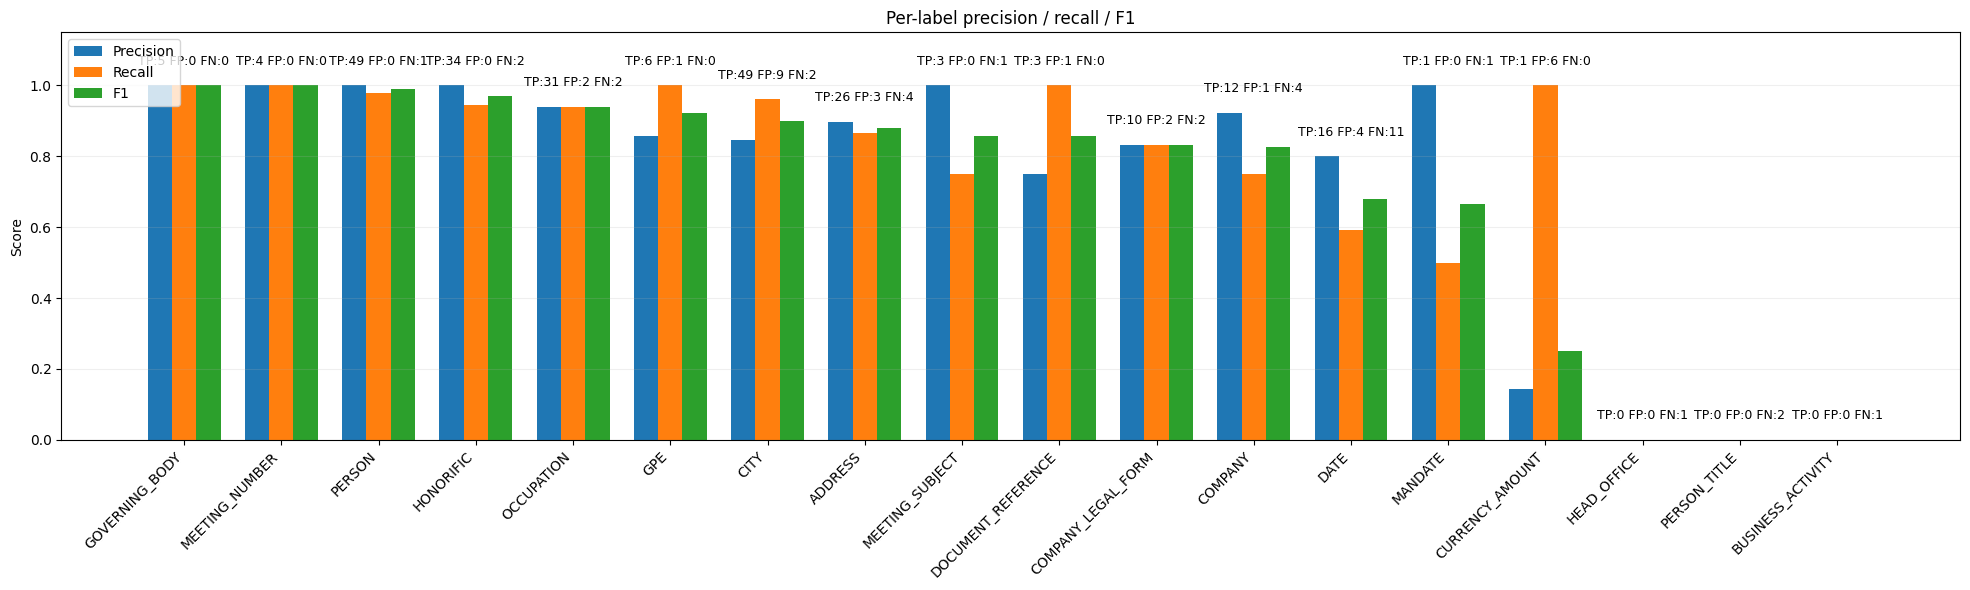

In [ ]:
# Visualization of overall and per-label metrics

import math

import pandas as pd

import matplotlib.pyplot as plt



# Build per-label table

rows = []

for label, counts in per_label_counts.items():

    tp = counts.get("tp", 0)

    fp = counts.get("fp", 0)

    fn = counts.get("fn", 0)

    prec = tp / (tp + fp) if tp + fp else 0.0

    rec = tp / (tp + fn) if tp + fn else 0.0

    f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) else 0.0

    rows.append({

        "label": label,

        "TP": tp,

        "FP": fp,

        "FN": fn,

        "Precision": prec,

        "Recall": rec,

        "F1": f1,

    })



per_label_df = pd.DataFrame(rows).sort_values(by="F1", ascending=False) if rows else pd.DataFrame()



# Overall table

overall_df = pd.DataFrame([

    {

        "scope": "Overall",

        "TP": totals["tp"],

        "FP": totals["fp"],

        "FN": totals["fn"],

        "Precision": overall_scores[0],

        "Recall": overall_scores[1],

        "F1": overall_scores[2],

    }

])



display(overall_df.style.format({"Precision": "{:.2%}", "Recall": "{:.2%}", "F1": "{:.2%}"}))

if not per_label_df.empty:

    display(per_label_df.style.format({"Precision": "{:.2%}", "Recall": "{:.2%}", "F1": "{:.2%}"}))

else:

    print("No per-label data available.")



# Bar chart for per-label metrics with counts annotated above bars

if not per_label_df.empty:

    labels = per_label_df["label"].tolist()

    x = range(len(labels))

    width = 0.25



    fig, ax = plt.subplots(figsize=(max(7, len(labels) * 1.1), 6))

    bars_p = ax.bar([i - width for i in x], per_label_df["Precision"], width, label="Precision")

    bars_r = ax.bar(x, per_label_df["Recall"], width, label="Recall")

    bars_f = ax.bar([i + width for i in x], per_label_df["F1"], width, label="F1")



    ax.set_ylabel("Score")

    ax.set_title("Per-label precision / recall / F1")

    ax.set_xticks(list(x))

    ax.set_xticklabels(labels, rotation=45, ha="right")

    ax.set_ylim(0, 1.15)

    ax.legend(loc="upper left")

    ax.grid(axis="y", alpha=0.2)



    # Annotate TP/FP/FN above each label group

    for i, label in enumerate(labels):

        tp = per_label_df.iloc[i]["TP"]

        fp = per_label_df.iloc[i]["FP"]

        fn = per_label_df.iloc[i]["FN"]

        max_bar = max(bars_p[i].get_height(), bars_r[i].get_height(), bars_f[i].get_height())

        ax.text(

            i, max_bar + 0.05,

            f"TP:{tp} FP:{fp} FN:{fn}",

            ha="center", va="bottom", fontsize=9, rotation=0,

        )



    plt.tight_layout()

    plt.show()


# Troubleshooting & FAQ {#troubleshooting}

## Common Errors & Solutions

### 1. `NameError: name 'create_gliner_schema_from_config_file' is not defined`

**Cause:** Schema loading functions not imported

**Solution:**
1. Scroll up to the cell under "Entity and Relation Schema Configuration"
2. Run that cell to import the functions
3. Retry the failing cell

---

### 2. `FileNotFoundError: [Errno 2] No such file or directory: '...'`

**Cause:** `SCHEMA_CONFIG_PATH` or input folder path is incorrect

**Solution:**
```python
# Check if file exists
import os
print(os.path.exists(SCHEMA_CONFIG_PATH))  # Should print True

# List files in folder to verify path
print(os.listdir(r'C:\path\to\folder'))
```

---

### 3. `CUDA out of memory` or `RuntimeError: CUDA Error`

**Cause:** GPU memory exhausted during batch processing

**Solutions:**
- **Option 1:** Process fewer files per run
- **Option 2:** Use smaller model: `gliner2-small-v1` instead of `gliner2-large-v1`
- **Option 3:** Use CPU instead (slower but less memory):
```python
# Force CPU usage
import torch
device = torch.device('cpu')
```

---

### 4. No entities extracted (empty results)

**Cause:** Schema labels don't match text content, or threshold too high

**Debugging steps:**
```python
# Step 1: Check threshold
print(f"Threshold: 0.3 (default)")  # Try lowering to 0.1

# Step 2: Verify schema labels exist
print(schema_config)  # Display loaded schema

# Step 3: Test with verbose output
result = extractor.extract(text, schema, include_confidence=True)
print(result)  # See confidence scores (if very low, threshold might be too high)
```

**Solutions:**
- Lower `threshold` parameter (e.g., `threshold=0.1`)
- Improve entity descriptions in `gliner_schema_template.json`
- Check that entity labels match your text domain
- Ensure text is longer than a few words

---

### 5. `ModuleNotFoundError: No module named 'gliner2'` or `gliner_to_labelstudio`

**Cause:** Required packages not installed

**Solution:**
```python
%pip install gliner2
%pip install --upgrade gliner2  # If already installed but outdated

# For the conversion module, ensure your sys.path includes the right folder
import sys
sys.path.insert(0, r'c:\Users\vducatte\OneDrive - UGent\Documents\BELHISFIRM\NER\gliner2-project')
```

---

### 6. Batch processing hangs or very slow

**Cause:** Processing large documents or too many files

**Solutions:**
- Check document size: `len(text)` should be < 10,000 characters ideally
- Split large documents manually
- Use `gliner2-small-v1` for speed
- Monitor with print statements to see progress

---

## Frequently Asked Questions

### Q: Why are my entities missing house numbers like "n 37"?
**A:** This is a known limitation. Try:
1. Update schema description: `"ADDRESS": "Street address including house number (may show as 'n 37')"`
2. Or preprocess: replace "n°" with "number"

### Q: Should I use English or French labels?
**A:** See the "Language Choice" section above. **Default: Use English** for most cases, but test on your data.

### Q: What threshold should I use?
**A:** Start with `0.3` (default). Lower it (0.1-0.2) for more liberal extraction, raise it (0.5+) for stricter. Balance your use case:
- **Annotator preference:** Lower (fewer things to correct)
- **Quality focus:** Higher (fewer false positives)

### Q: How long does batch processing take?
**A:** Roughly **1-2 seconds per document** with `gliner2-multi-v1`. A 100-document batch = 2-3 minutes.

### Q: Can I resume interrupted batch processing?
**A:** Currently, no. Best practice:
- Process in smaller batches
- Save results frequently
- Restart without duplicate processing

### Q: How do I know if my schema is good?
**A:** Look at confidence scores:
- Average > 0.7: Good schema
- Average 0.4-0.7: Consider improving descriptions
- Average < 0.4: Likely issues with labels or text format

### Q: Can I use this for other languages?
**A:** Yes! GLiNER2 multilingual models support 100+ languages. Just:
1. Update entity names/descriptions in schema to your language
2. Provide example text in your language
3. Run extraction

### Q: How do I export results for analysis?
**A:** All batch results are available in `results_batch` (list of dicts). Export with:
```python
import json
with open('my_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_batch, f, indent=2, ensure_ascii=False)
```

---

## Getting Help

If you encounter issues not listed above:

1. **Check the error message carefully** - copy the full traceback
2. **Review GLiNER2 documentation** - https://github.com/fastino-ai/GLiNER2
3. **Check Label Studio docs** - https://labelstud.io/guide
4. **Validate your inputs** - ensure schema file and text files are correctly formatted JSON/text